# Parametric shape optimization with differentiable FEM simulation


## Setup

In [1]:
# Install additional requirements for this notebook
# %pip install -r requirements.txt -q --isolated

In [2]:
# import tesseract_core

# tesseract_core.build_tesseract("sdf_fd_tess", "latest")
# tesseract_core.build_tesseract("fem_tess", "latest")
# tesseract_core.build_tesseract("meshing_tess", "latest")
# print("Tesseract built successfully.")

In [1]:
# The PyMAPDL Host (X.X.X.X IP Address) and Port (XXX) are pulled from the environment
import os

HOST = os.getenv("MAPDL_HOST")
HOST = "172.26.3.35"
if HOST is None:
    raise ValueError(
        "Unable to read $MAPDL_HOST from the environment. "
        + "Use 'export MAPDL_HOST=X.X.X.X' for local IP address of your MAPDL Instance."
    )
PORT = os.getenv("MAPDL_PORT")
PORT = "50052"
if PORT is None:
    raise ValueError(
        "Unable to read $MAPDL_PORT from the environment. "
        + "Use 'export MAPDL_PORT=X' for the port of your MAPDL Instance."
    )

## Design Space Tesseract

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tesseract_core import Tesseract
from tesseract_core.runtime.experimental import TesseractReference
from utils import (
    MMAOptimizer,
    hex_grid,
    hex_to_pyvista,
    plot_grid,
    plot_grid_slice,
    plot_mesh,
)

from tesseract_jax import apply_tesseract

In [3]:
design_tess = Tesseract.from_tesseract_api("sdf_fd_tess/tesseract_api.py")
# design_tess = Tesseract.from_image("sdf_fd_tess")
# design_tess.serve()
bar_3d_tess = Tesseract.from_tesseract_api("bars_3d_tess/tesseract_api.py")

Now we can setup the parameters for the design space and apply the design Tesseract. The Tesseract constructs a 3D geometry using PyVista and computes its signed distance field (SDF).

In [4]:
n_chains = 2
n_edges_per_chain = 3
bar_radius = 1.2

Lx, Ly, Lz = 20.0, 5.0, 10.0
Nx, Ny, Nz = 64, 16, 32

# Initialize chain parameter array
initial_params = jnp.zeros((n_chains, n_edges_per_chain + 1, 3), dtype=jnp.float32)

for chain in range(n_chains):
    initial_params = initial_params.at[chain, :, 0].set(
        jnp.linspace(-Lx / 2, Lx / 2, n_edges_per_chain + 1)
    )

    initial_params = initial_params.at[chain, :, 2].set(
        (chain + 1) / (n_chains + 1) * Ly - Ly / 2
    )

initial_params = initial_params.flatten()

normalization_factors = jnp.ones_like(initial_params, dtype=jnp.float32) * 0.1
initial_params = initial_params * normalization_factors
normalization_bias = jnp.zeros_like(initial_params, dtype=jnp.float32)


design_inputs = {
    "non_differentiable_parameters": jnp.array([bar_radius], dtype=jnp.float32),
    "static_parameters": [n_chains, n_edges_per_chain + 1],
    "string_parameters": [],
    "mesh_tesseract": TesseractReference(bar_3d_tess),
    "grid_size": [Lx, Ly, Lz],
    "grid_elements": [Nx, Ny, Nz],
    "epsilon": 0.001,  # epsilon, only used for FD of the jacobian
    "grid_center": [0.0, 0.0, 0.0],
    "max_points": 2000,
    "max_faces": 4000,
    "normalization_factors": normalization_factors,
    "normalization_bias": normalization_bias,
    "normalize_jacobian": False,
    "precompute_jacobian": False,
    "sdf_backend": "pyvista",
}

design_out = design_tess.apply(
    {
        "differentiable_parameters": initial_params,
        **design_inputs,
    }
)
sdf = design_out["sdf"]
surface_mesh = design_out["mesh"]

num_vertices = surface_mesh["n_points"]
num_faces = surface_mesh["n_faces"]

print(f"Number of vertices: {num_vertices}")
print(f"Number of faces: {num_faces}")

points = surface_mesh["points"][:num_vertices]
faces = surface_mesh["faces"][:num_faces]

mesh = {
    "points": points,
    "faces": faces,
}

print("SDF shape:", sdf.shape)

Number of vertices: 202
Number of faces: 400
SDF shape: (64, 16, 32)


To better understand what's going on, let's import some internal functions from the design Tesseract, and visualize the structure and its SDF field.

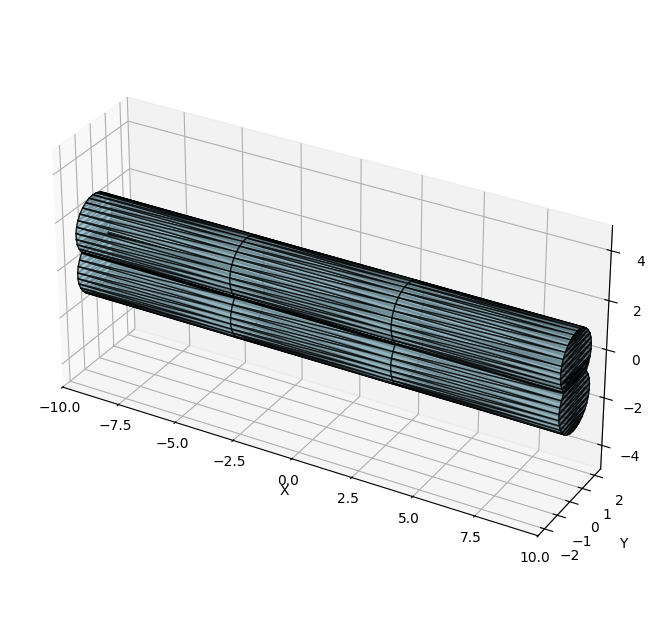

In [5]:
plot_mesh(mesh, [Lx, Ly, Lz])

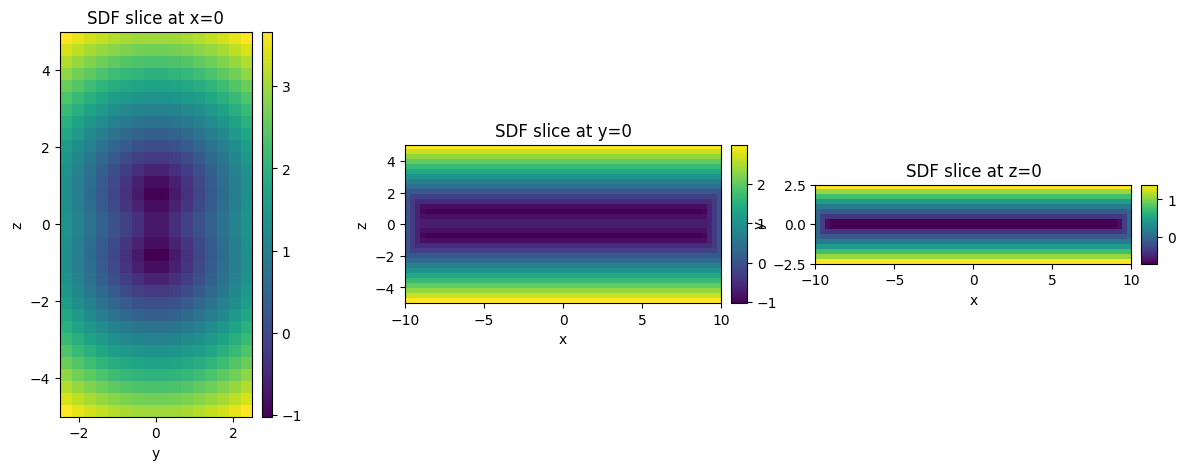

In [6]:
plot_grid(sdf, Lx, Ly, Lz, Nx, Ny, Nz, "SDF")

In [7]:
result = design_tess.jacobian(
    inputs={
        "differentiable_parameters": initial_params,
        **design_inputs,
    },
    jac_inputs=["differentiable_parameters"],
    jac_outputs=["sdf"],
)

Computing Jacobian...


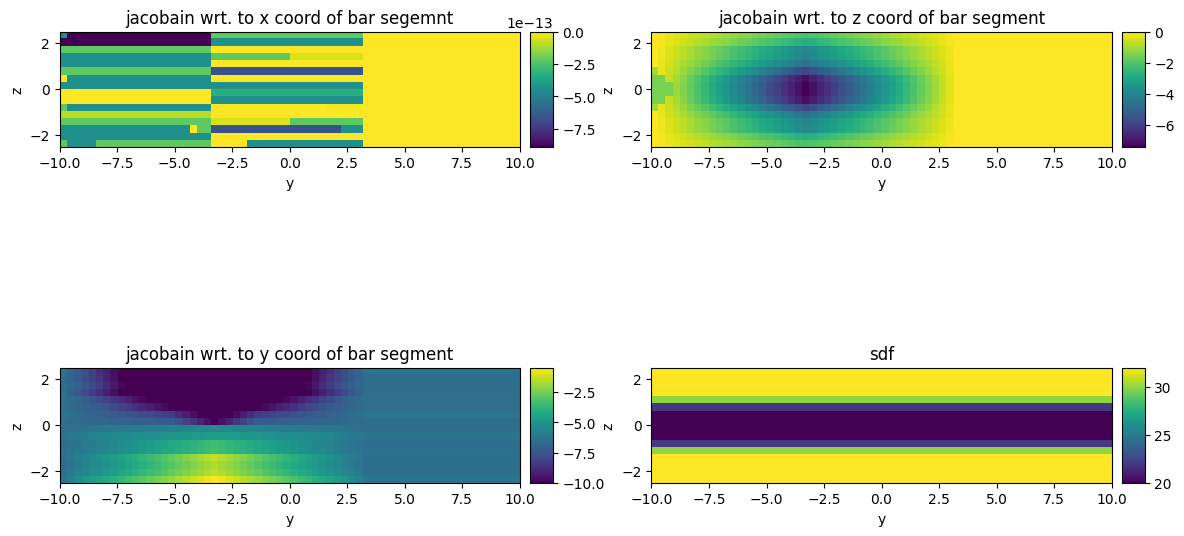

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

plot_grid_slice(
    jnp.min(jnp.clip(result["sdf"]["differentiable_parameters"][3], -10, 0), 2),
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[0, 0],
    title="jacobain wrt. to x coord of bar segemnt",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    jnp.min(jnp.clip(result["sdf"]["differentiable_parameters"][4], -10, 0), 2),
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[1, 0],
    title="jacobain wrt. to y coord of bar segment",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    jnp.min(jnp.clip(result["sdf"]["differentiable_parameters"][5], -10, 0), 2),
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[0, 1],
    title="jacobain wrt. to z coord of bar segment",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    jnp.sum(sdf > 0, 2),
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[1, 1],
    title="sdf",
    xlabel="y",
    ylabel="z",
)

## Density Variation

rho min: 0.0007239776896312833, rho max: 0.8956337571144104


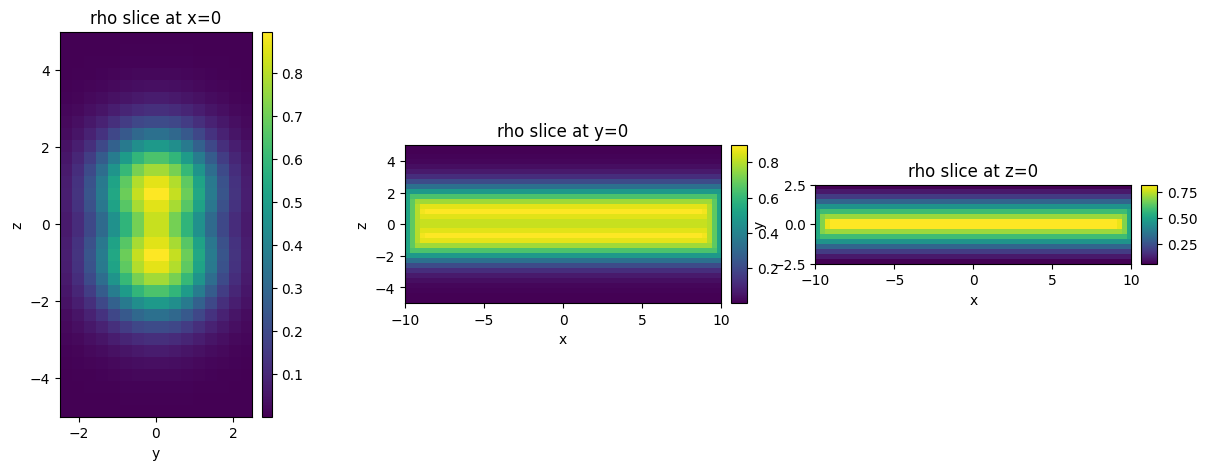

In [9]:
def sdf_to_rho(
    sdf: jnp.ndarray, scale: float = 2.0, offset: float = 0.1
) -> jnp.ndarray:
    """Convert signed distance function to material density using sigmoid.

    Args:
        sdf: Signed distance function values.
        scale: Sigmoid steepness (higher = sharper transition).
        offset: SDF value where density = 0.5.

    Returns:
        Material density field in [0,1].
    """
    return 1 / (1 + jnp.exp(scale * sdf - offset))


rho = sdf_to_rho(sdf, scale=2)

plot_grid(rho, Lx, Ly, Lz, Nx, Ny, Nz, "rho")
print(f"rho min: {jnp.min(rho)}, rho max: {jnp.max(rho)}")

## Hex Mesh

In [11]:
points, cells = hex_grid(Lx, Ly, Lz, Nx + 1, Ny + 1, Nz + 1)

hex_mesh = {
    "points": points,
    "faces": cells,
    "n_points": jnp.array(points.shape[0]),
    "n_faces": jnp.array(cells.shape[0]),
}

Lets examine the produced mesh by exporting it to a VTK file and visualizing it in Paraview.

In [12]:
pv_mesh = hex_to_pyvista(
    hex_mesh["points"],
    hex_mesh["faces"],
    {"rho": rho.flatten()},
)

print(pv_mesh)

pv_mesh.save("tmp_vtks/bars_mesh.vtk")

UnstructuredGrid (0x7daedc2d1960)
  N Cells:    32768
  N Points:   36465
  X Bounds:   -1.000e+01, 1.000e+01
  Y Bounds:   -2.500e+00, 2.500e+00
  Z Bounds:   -5.000e+00, 5.000e+00
  N Arrays:   1


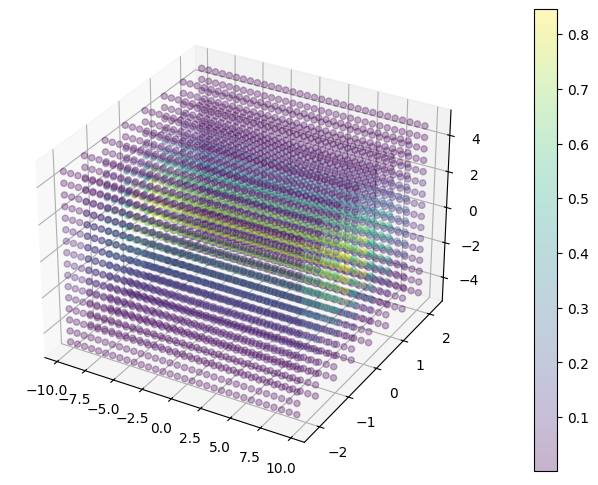

In [28]:
# lets make a scatter plot of the mesh cell values as colors
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={"projection": "3d"})
pts_coords = hex_mesh["points"]
hex_cells = hex_mesh["faces"]
center_points = jnp.mean(pts_coords[hex_cells], axis=1)
rho_mesh = rho.flatten()
scat = ax.scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=rho_mesh,
    s=20,
    alpha=0.3,
    cmap="viridis",
)
# colorbar
cbar = plt.colorbar(scat, ax=ax, pad=0.1)

## Boundary Conditions

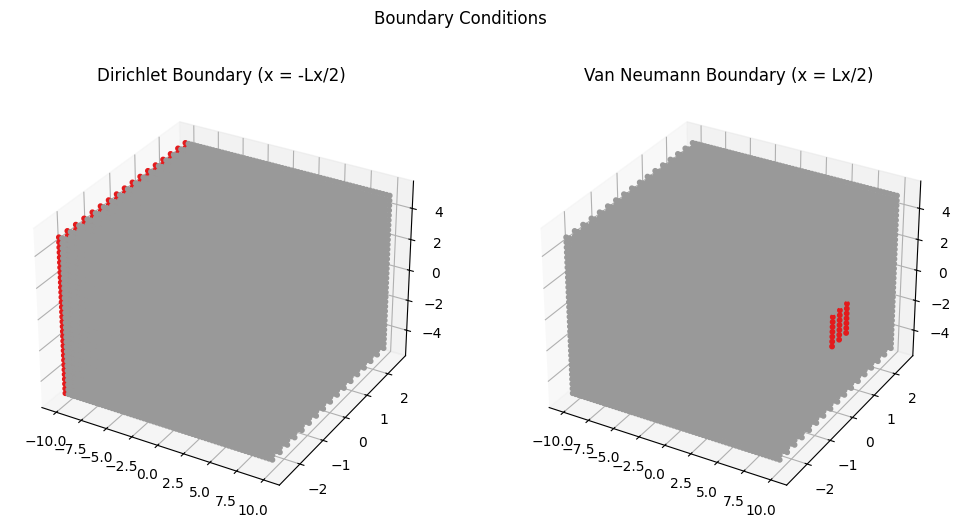

In [13]:
# Lets setup the boundary conditions


def get_boundary_masks(mesh: dict, Lx: float, Ly: float, Lz: float):
    """Get boundary condition masks for the adaptive mesh.

    Args:
        mesh: Dictionary containing 'points' array.
        Lx: Size of the domain in x-direction.
        Ly: Size of the domain in y-direction.
        Lz: Size of the domain in z-direction.

    Returns:
        dirichlet_mask: Boolean array for Dirichlet boundary condition.
        van_neumann_mask: Boolean array for Van Neumann boundary condition.
    """
    pts = mesh["points"]

    dirichlet_mask = pts[:, 0] <= -Lx / 2
    # von Neumann condition (select nodes at x=Lx with constraints on y and z)
    x_lim = Lx / 2
    y_min = -0.1 * Ly
    y_max = 0.1 * Ly
    z_min = -0.1 * Lz
    z_max = 0.1 * Lz
    van_neumann_mask = jnp.logical_and(
        hex_mesh["points"][:, 0] >= x_lim,
        jnp.logical_and(
            jnp.logical_and(
                hex_mesh["points"][:, 1] >= y_min, hex_mesh["points"][:, 1] <= y_max
            ),
            jnp.logical_and(
                hex_mesh["points"][:, 2] >= z_min, hex_mesh["points"][:, 2] <= z_max
            ),
        ),
    )

    return dirichlet_mask, van_neumann_mask


dirichlet_mask, van_neumann_mask = get_boundary_masks(hex_mesh, Lx, Ly, Lz)

fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))
# set the colormap to Set1
plt.suptitle("Boundary Conditions")
# remove the axis ticks
pts = hex_mesh["points"]
axs[0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(dirichlet_mask, 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[0].set_title("Dirichlet Boundary (x = -Lx/2)")

axs[1].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(van_neumann_mask, 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[1].set_title("Van Neumann Boundary (x = Lx/2)")

# convert to int arrays for tesseract input
dirichlet_mask = dirichlet_mask.astype(jnp.int32)
van_neumann_mask = van_neumann_mask.astype(jnp.int32)

## Finite Element Analysis

In [14]:
# load the Finite Element Method Tesseract
fem_tess = Tesseract.from_tesseract_api("pymapdl_tess/tesseract_api.py")
# fem_tess = Tesseract.from_image("pymapdl_tess")
# fem_tess.serve()

In [32]:
# TODO unify this framework
dirichlet_idx = jnp.where(dirichlet_mask)[0]
von_neumann_idx = jnp.where(van_neumann_mask)[0]
von_neumann_values = jnp.array([0, 0.0, 0.1]) + jnp.zeros((von_neumann_idx.shape[0], 3))

c = apply_tesseract(
    fem_tess,
    {
        "dirichlet_mask": dirichlet_idx,
        "dirichlet_values": jnp.zeros(dirichlet_idx.size),
        "van_neumann_mask": von_neumann_idx,
        "van_neumann_values": von_neumann_values,
        "hex_mesh": hex_mesh,
        "host": HOST,
        "port": PORT,
        "rho": jnp.expand_dims(rho.flatten(), axis=-1),
        "E0": 1.0,
        "rho_min": 1e-6,
        "log_level": "DEBUG",
        "vtk_output": "mesh_density.vtk",
    },
)["compliance"]

print(f"Compliance: {c:.4f}")

2025-11-25 12:39:02,579 - tesseract_api - INFO - Starting solve...
2025-11-25 12:39:02,581 - tesseract_api - INFO - Starting SIMP elasticity analysis...
2025-11-25 12:39:02,582 - tesseract_api - INFO - Starting _create_mesh...
2025-11-25 12:39:02,611 - tesseract_api - INFO - Starting _define_element...
2025-11-25 12:39:02,661 - tesseract_api - INFO - Completed _define_element in 0.0505 seconds
2025-11-25 12:39:02,664 - tesseract_api - INFO - Creating 5049 nodes...
2025-11-25 12:39:04,419 - tesseract_api - INFO - Creating 4096 hexahedral elements...
2025-11-25 12:39:06,257 - tesseract_api - INFO - Mesh created: 5049 nodes, 4096 elements
2025-11-25 12:39:06,259 - tesseract_api - INFO - Verified: Node and element numbering is sequential (1, 2, 3, ...)
2025-11-25 12:39:06,260 - tesseract_api - INFO - Completed _create_mesh in 3.6782 seconds
2025-11-25 12:39:06,261 - tesseract_api - INFO - Starting _define_simp_materials...
2025-11-25 12:39:07,923 - tesseract_api - INFO - Completed _define_

Compliance: 79.0651


## Optimization Setup

In [15]:
from jax import custom_vjp

grad_storage = {}


def store_values(x, x_dot, hash_val: int):
    global grad_storage
    print("Storing values in hash", hash_val)
    grad_storage[int(hash_val)] = (x, x_dot)


@custom_vjp
def identity_and_store_grads(x, hash_val: int):
    return x


def identity_fwd(x, hash_val):
    return x, (x, hash_val)


def identity_bwd(residuals, g):
    x, hash_val = residuals
    jax.debug.callback(store_values, x, g, hash_val, ordered=False)
    return (g, None)


identity_and_store_grads.defvjp(identity_fwd, identity_bwd)

In [16]:
def loss(
    params: jnp.ndarray,
    iteration: int = 0,
) -> tuple[float, dict]:
    """Compute structural compliance for given bar parameters.

    Args:
        params: Bar parameter array with shape (n_chains, n_nodes, 3).
        iteration: current optim iteration.

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    # Generate signed distance field from design parameters
    # params = identity_and_store_grads(params, iteration + 0)
    design_out = apply_tesseract(
        design_tess,
        {"differentiable_parameters": params.flatten(), **design_inputs},
    )

    sdf = design_out["sdf"]
    sdf = identity_and_store_grads(sdf, iteration + 1000)

    # Convert SDF to material density distribution
    rho_grid = sdf_to_rho(sdf, scale=2)
    rho_grid = identity_and_store_grads(rho_grid, iteration + 2000)

    # calculate BCs
    dirichlet_mask, van_neumann_mask = get_boundary_masks(hex_mesh, Lx, Ly, Lz)

    van_neumann_mask = jax.lax.stop_gradient(van_neumann_mask)
    dirichlet_mask = jax.lax.stop_gradient(dirichlet_mask)
    # dirichlet_values = jnp.array([0.0])
    # van_neumann_values = jnp.array([[0.0, 0.0, 0.1]])

    # TODO unify this framework
    dirichlet_idx = jnp.where(dirichlet_mask)[0]
    von_neumann_idx = jnp.where(van_neumann_mask)[0]
    von_neumann_values = jnp.array([0, 0.0, 0.1]) + jnp.zeros(
        (von_neumann_idx.shape[0], 3)
    )

    c = apply_tesseract(
        fem_tess,
        {
            "dirichlet_mask": dirichlet_idx,
            "dirichlet_values": jnp.zeros(dirichlet_idx.size),
            "van_neumann_mask": von_neumann_idx,
            "van_neumann_values": von_neumann_values,
            "hex_mesh": hex_mesh,
            "host": HOST,
            "port": PORT,
            "rho": jnp.expand_dims(rho_grid.flatten(), axis=-1),
            "E0": 1.0,
            "rho_min": 1e-6,
            "log_level": "WARNING",
            "vtk_output": None,
        },
    )["compliance"]

    return c, {"sdf": sdf, "rho_grid": rho_grid}


grad_fn = jax.value_and_grad(loss, has_aux=True)

## Lets have a look at the gradients

In [35]:
(loss_value, aux), grads = grad_fn(initial_params, iteration=0)
print(f"loss {loss_value}, grads {grads}")

Storing values in hash 2000
Storing values in hash 1000
Computing Jacobian...
loss 79.0650863647461, grads [ 9.7714203e+01  1.5442065e+02  2.4776456e+02  3.0906896e-12
  1.5455754e+02  2.5515326e+02  8.8487816e-13  1.5457144e+02
  7.0407928e+01 -8.7040701e+00  1.5456490e+02  5.5683441e+00
  9.7714203e+01  1.5442024e+02 -2.4789474e+02  9.3546601e-13
  1.5455771e+02 -2.5508614e+02  3.0393494e-13  1.5457141e+02
 -7.0390312e+01 -8.7040701e+00  1.5456488e+02 -5.5969892e+00]


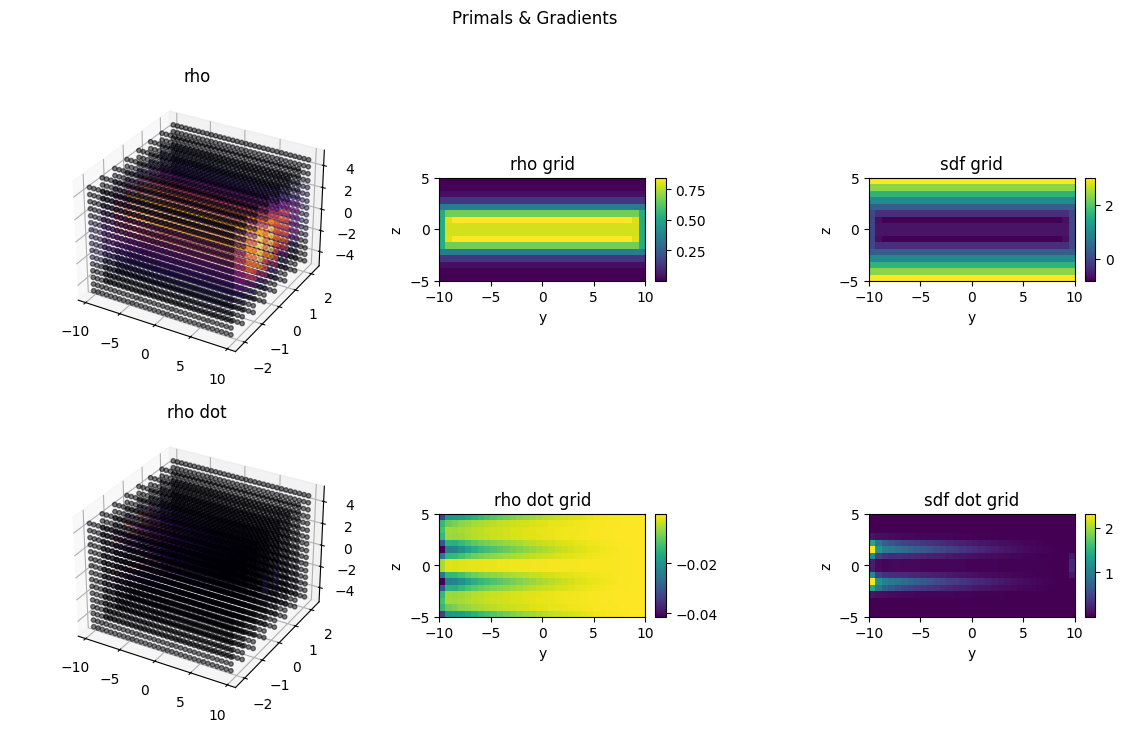

In [36]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8))
plt.suptitle("Primals & Gradients")
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])

ax = axs[0, 0]
for spine in ax.spines.values():
    spine.set_visible(False)

ax = axs[1, 0]
for spine in ax.spines.values():
    spine.set_visible(False)

# Set the first two subplots to 3D
axs[0, 0] = fig.add_subplot(2, 2, 1, projection="3d")
axs[1, 0] = fig.add_subplot(2, 2, 3, projection="3d")


mesh = hex_mesh

pts_coords = mesh["points"]
hex_cells = mesh["faces"]
pts = jnp.mean(pts_coords[hex_cells], axis=1)

axs[0, 0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=aux["rho_grid"],
    s=10,
    alpha=0.5,
    cmap="inferno",
)
axs[0, 0].set_title("rho")

axs[1, 0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=-grad_storage[2000][1],
    s=10,
    alpha=0.5,
    cmap="inferno",
)
axs[1, 0].set_title("rho dot")

plot_grid_slice(
    aux["rho_grid"][:, Ny // 2, :],
    extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
    ax=axs[0, 1],
    title="rho grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    jnp.max(grad_storage[2000][1], axis=1),
    extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
    ax=axs[1, 1],
    title="rho dot grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    aux["sdf"][:, Ny // 2, :],
    extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
    ax=axs[0, 2],
    title="sdf grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    jnp.max(grad_storage[1000][1], axis=1),
    extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
    ax=axs[1, 2],
    title="sdf dot grid",
    xlabel="y",
    ylabel="z",
)

fig.subplots_adjust(wspace=0.9)

### Finite difference check

In [38]:
params = initial_params.copy()

(loss_value, aux), grads = grad_fn(params, iteration=0)

# Finite difference check
run_central_difference = False
num_tests = 3
FD_delta = 1.0e-4
FD_grads = 0 * jnp.array(grads)
for i in range(num_tests):
    print(i)
    params_up = params.at[i].add(FD_delta)
    (fupp, _), _ = grad_fn(params_up, iteration=i * 2)

    if run_central_difference:
        params_down = params.at[i].subtract(2.0 * FD_delta)
        (fdown, _), _ = grad_fn(params_down, iteration=i * 2 + 1)
        FD_grads = FD_grads.at[i].set((fupp - fdown) / FD_delta / 2.0)

    else:
        FD_grads = FD_grads.at[i].set((fupp - loss_value) / FD_delta)

if num_tests > 0:
    sens = jnp.array(grads[0:num_tests])
    FD_sens = FD_grads[0:num_tests]
    print(sens)
    print(FD_sens)
    errors = sens - FD_sens
    print(errors)
    rel_abs_error = jnp.abs(errors / sens)
    if run_central_difference:
        print(f"Relative error should be near O({FD_delta})")
    else:
        print(f"Relative error should be O({FD_delta * 10})")
    print(rel_abs_error)

Storing values in hash 2000
Storing values in hash 1000
Computing Jacobian...
0
Storing values in hash 2000
Storing values in hash 1000
Computing Jacobian...
1
Storing values in hash 2002
Storing values in hash 1002
Computing Jacobian...
2
Storing values in hash 2004
Storing values in hash 1004
Computing Jacobian...
3
Storing values in hash 2006
Storing values in hash 1006
Computing Jacobian...
4
Storing values in hash 2008
Storing values in hash 1008
Computing Jacobian...
5
Storing values in hash 2010
Storing values in hash 1010
Computing Jacobian...
6
Storing values in hash 2012
Storing values in hash 1012
Computing Jacobian...
7
Storing values in hash 2014
Storing values in hash 1014
Computing Jacobian...
8
Storing values in hash 2016
Storing values in hash 1016
Computing Jacobian...
9
Storing values in hash 2018
Storing values in hash 1018
Computing Jacobian...
10
Storing values in hash 2020
Storing values in hash 1020
Computing Jacobian...
11
Storing values in hash 2022
Storing va

## Design Optimization using MMA

In [ ]:
import importlib

import utils

importlib.reload(utils)
n_steps = 20

# set design bounds by a perturbation value 'delta'
delta_x = 0.0
delta_y = 0.0
delta_z = Lz / 3
eps = 1.0e-3  # a small value to ease numerics
bar_params = jnp.array(initial_params).reshape(n_chains, n_edges_per_chain + 1, 3)
param_min = bar_params - eps
param_max = bar_params + eps
for bar_idx, bar in enumerate(bar_params):
    for coord_idx, _xyz in enumerate(bar):
        for i, delta in enumerate([delta_x, delta_y, delta_z]):
            param_min = param_min.at[bar_idx, coord_idx, i].add(-delta)
            param_max = param_max.at[bar_idx, coord_idx, i].add(delta)

param_min = param_min.flatten().at[:, None].get()
param_max = param_max.flatten().at[:, None].get()

# A placeholder is used for constraint
num_constraints = 0
g = jnp.zeros((0, 1))
dgdx = jnp.zeros((0, initial_params.shape[0]))

# initialize the optimizer
x_update_limit = 0.005
params = initial_params.copy()
loss_hist = []
params_hist = []
aux_hist = []
optimizer = MMAOptimizer(
    initial_params[:, None],
    param_min,
    param_max,
    num_constraints,
    x_update_limit=x_update_limit,
)


for i in range(n_steps):
    (loss_value, aux), grads = grad_fn(params, iteration=i)
    print(loss_value)
    print(params)
    print(grads)
    np_params = optimizer.calculate_next_x(loss_value, grads, g, dgdx, i + 1, params)
    params = jnp.array(np_params.flatten())

    loss_hist.append(loss_value)
    params_hist.append(params)
    aux_hist.append(aux)

    print(f"Iteration {i + 1}, Loss: {loss_value:.4f}")

Storing values in hash 2000
Storing values in hash 1000
Computing Jacobian...
3282.4985
[-1.          0.         -0.08333334 -0.33333328  0.         -0.08333334
  0.3333334   0.         -0.08333334  1.          0.         -0.08333334
 -1.          0.          0.08333334 -0.33333328  0.          0.08333334
  0.3333334   0.          0.08333334  1.          0.          0.08333334]
[ 2.5389253e+03 -4.4800562e+03  1.0346361e+04 -5.8138112e-12
 -4.4937363e+03  1.1137594e+04  1.4027594e-11 -4.5147461e+03
  3.0415300e+03 -2.2169554e+02 -4.5216631e+03  2.0970651e+02
  2.5389250e+03 -4.4800361e+03 -1.0353295e+04 -1.5549662e-11
 -4.4937422e+03 -1.1133140e+04 -6.3771124e-13 -4.5147437e+03
 -3.0517241e+03 -2.2169554e+02 -4.5216631e+03 -2.2294655e+02]
Iteration 1, Loss: 3282.4985


### Optimization Postprocess

Text(0.5, 1.0, 'Compliance over Optimization')

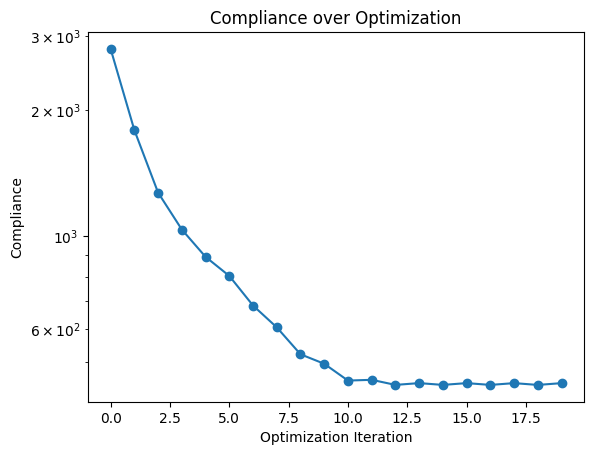

In [20]:
plt.plot(loss_hist, marker="o")
plt.yscale("log")
plt.xlabel("Optimization Iteration")
plt.ylabel("Compliance")
plt.title("Compliance over Optimization")

In [21]:
for i in range(n_steps):
    mesh = hex_mesh
    rho_dot = grad_storage[i + 2000][1][: len(mesh["faces"])]
    pv_mesh = hex_to_pyvista(
        mesh["points"],
        mesh["faces"],
        {"rho": aux_hist[i]["rho_grid"].T.flatten(), "rho_dot": rho_dot.T.flatten()},
    )
    pv_mesh.save(f"vtks/fem_shapeopt_mesh{i + 1}.vtk")

In [22]:
from matplotlib import animation

# repeat the last frame a few times to show the final result
params_hist = params_hist + [params] * 20

fig = plt.figure(figsize=(7, 4))

design_inputs["precompute_jacobian"] = False

ims = []
for aux in aux_hist:
    sdf = aux["sdf"]

    im = plt.imshow((sdf[:, :, :] > 0).sum(axis=1).T, origin="lower", cmap="viridis")
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=10, blit=False, repeat_delay=2)
plt.close(fig)

ani.save("rho_bars_optim.gif", writer="pillow", fps=10)